In [1]:
import math
import numpy
import cv2
from scipy.io import wavfile
import matplotlib.pyplot as plt

## DCT1D

$$X[k]\left(\dfrac{2}{N}\right)^{1/2} c_k \sum_{n=0}^{N-1}x[n] \cos\left[2\pi \dfrac{k}{2N}n +\dfrac{k\pi}{2N}\right], k=0,1, \dots, N-1  $$

 $$\text{Onde } c_k = \left\{
		\begin{aligned}
			\left(\dfrac{1}{2}\right)^{1/2} & \text{ para } &k = 0 \\
			1 & \text{ para } & 1, 2, \dots, N-1\\	
		\end{aligned}
	\right.$$

In [2]:
def dct1d(x):    
    N = len(x)
    k_range = [k for k in range(N)]
    c_k = [math.sqrt(0.5) if k == 0 else 1 for k in k_range]
    factor = [(math.pi*k)/(2*N) for k in k_range]
    result = numpy.zeros(N)
    for k in k_range:
        x_k = 0
        for n in range(N):
            x_k += x[n] * math.cos(2*n*factor[k]+factor[k])
        result[k] = x_k * (math.sqrt(2/N)) * c_k[k]  
    return result

## DCT2D

$$X[k,l] = \dfrac{2}{\sqrt{RC}}c_kc_l \sum_{m=0}^{R-1} \sum_{n=0}^{C-1} x[m,n] \cos \left(\dfrac{(2m+1)k\pi}{2R}\right) \cos\left[\dfrac{(2n +1)l\pi}{2C}\right]$$

In [3]:
def dct2d(x):
    result = numpy.array(list(map(dct1d, x))).transpose()
    result = numpy.array(list(map(dct1d, result))).transpose()
    return list(result)

## Normalização

$$\log (|\text{DCT}| +1) $$

In [4]:
def dct_norm(dct):
    dct = numpy.copy(dct)
    dct_normalized = numpy.log(numpy.abs(dct) + 1)
    dct_normalized *= (255.0/dct_normalized.max())
    return list(dct_normalized)

## IDCT1D

$$x[n] \left(\dfrac{2}{N}\right)^{1/2}  \sum_{k=0}^{N-1} c_k X[k] \cos \left[2\pi\dfrac{k}{2N}n+\dfrac{k\pi}{2N}\right], n = 0,1, \dots ,N-1 $$

In [5]:
def idct1d(x: numpy.array) -> numpy.array:
    N = len(x)
    k_range = [k for k in range(N)]
    c_k = [math.sqrt(0.5) if k == 0 else 1 for k in k_range]
    factor = [(math.pi*k)/(2*N) for k in k_range]
    result = numpy.zeros(N)
    for n in range(N):
        x_n = 0
        for k in k_range:
            x_n += c_k[k] * x[k] * math.cos((2*n*factor[k]+factor[k]))
        x_n *= (math.sqrt(2/N))
        result[n] = x_n
    return result

## IDCT2D

$$x[m,n] = \dfrac{2}{\sqrt{RC}} \sum_{m=0}^{R-1} \sum_{n=0}^{C-1}c_kc_l X[k,l] \cos \left(\dfrac{(2m+1)k\pi}{2R}\right) \cos \left[\dfrac{(2n +1)l\pi}{2C}\right]$$

In [6]:
def idct2d(x):
    result = numpy.array(list(map(idct1d, x))).transpose()
    result = numpy.array(list(map(idct1d, result))).transpose()
    return list(result)

## Filtro Butterworth Imagem

$$  H(d(k,l)) = \dfrac{1}{1 +\left( \dfrac{d(k,l)}{f_c}\right)^{2n}} $$

In [7]:
def ButterworthImagem(d, fc, n, Xk):
    for k in range (d.shape[0]):
        for l in range (d.shape[1]):
            d[k][l] = math.sqrt(pow(k, 2) + pow(l, 2))
            H = 1/(math.sqrt(1 +pow((d[k][l]/fc), 2*n)))
            Xk[k][l] = H*Xk[k][l]      
    return Xk

## Filtro Butterworth Áudio

$$H(f) \dfrac{1}{\left(\dfrac{f}{f_c}^{2n}\right)}$$

In [8]:
def ButterworthAudio(audio, fc, n, Xk):
    signal_size = audio[1].shape[0]
    f= numpy.empty([signal_size])
    fa = audio[0]
    f1 = (fa / (2 * (signal_size - 1)))
    
    for k in range(0, signal_size):
        f[k] = k * f1   

    for k in range (0,f.shape[0]): 
        H = 1/(math.sqrt(1 +pow((f[k]/fc), 2*n)))
        Xk[k] = H*Xk[k]    
    return Xk

In [9]:
def readImg(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img

def printImg(img):    
    plt.rcParams['figure.figsize'] = (6,6) 
    plt.imshow(img, cmap = 'gray')
    plt.show()

In [10]:
def readAud(filename):
    audio = wavfile.read(filename)
    return audio

def printAud(audio, title):
    plt.figure("Data", figsize=[6,6])
    plt.plot(audio, linewidth=0.5,alpha=1,color="blue")
    plt.title(title)
    plt.ylabel("Amplitude")
    plt.show()
    
def saveAud(rate,audio): 
    wavfile.write("output_audio.wav", rate, audio.astype(numpy.int16))

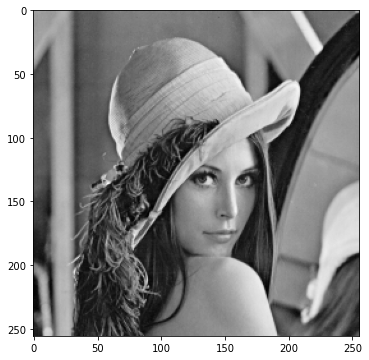

In [11]:
img = readImg('lena256.png')
printImg(img)

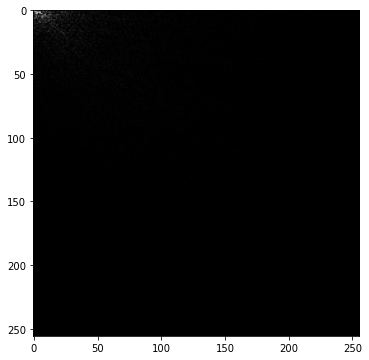

Módulo DC = 31883.609375000007


In [12]:
img_dct = dct2d(img)
dc = img_dct[0][0]
img_dct[0][0] = 0.0
numpy.save('imagem_dct',img_dct)
printImg(numpy.abs(img_dct))
print("Módulo DC =", dc)

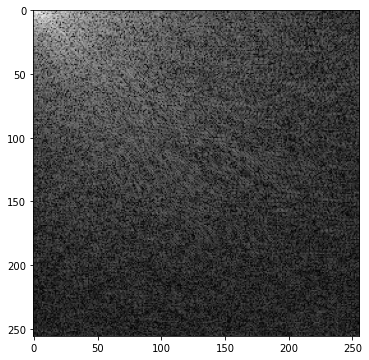

In [13]:
img_dct_norm = dct_norm(img_dct)
printImg(numpy.abs(img_dct_norm))

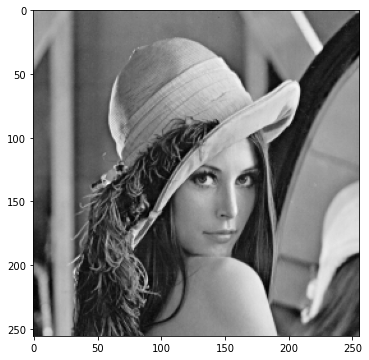

In [14]:
    img_dct = numpy.load('imagem_dct.npy')
    img_idct = idct2d(img_dct)
    printImg(img_idct)

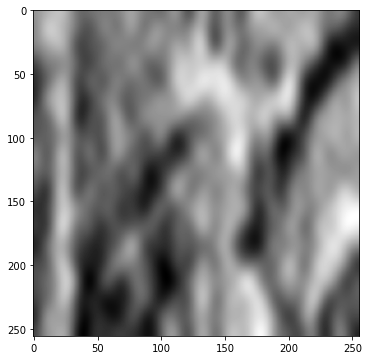

100


In [15]:
img_dct[0][0] = dc
dct_only11 = numpy.argpartition(numpy.abs(img_dct).flatten(), -100)[-100:]
teste = numpy.vstack(numpy.unravel_index(dct_only11, numpy.copy(dct_norm(img_dct)).shape)).T
new_matrix = numpy.zeros((256,256))

for x in teste:
    new_matrix[x[0]][x[1]] = numpy.copy(img_dct)[x[0]][x[1]]
    
printImg(idct2d(new_matrix))
print(len([x for x in new_matrix.flatten() if x != 0]))

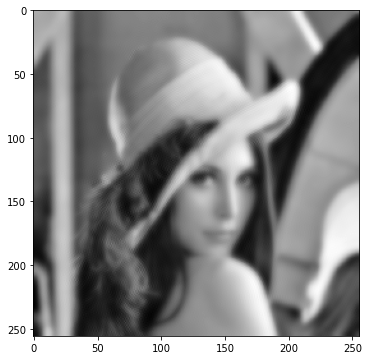

In [16]:
k = ButterworthImagem(img, 30, 2, img_dct)
img_idct_bt = idct2d(k)
printImg(img_idct_bt)

C:\Users\geanr\AppData\Local\Temp\ipykernel_14200\2752526504.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio = wavfile.read(filename)


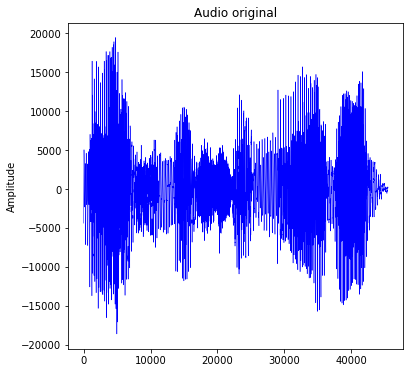

In [17]:
audio = readAud("MaisUmaSemana.wav")
printAud(audio[1], 'Audio original')

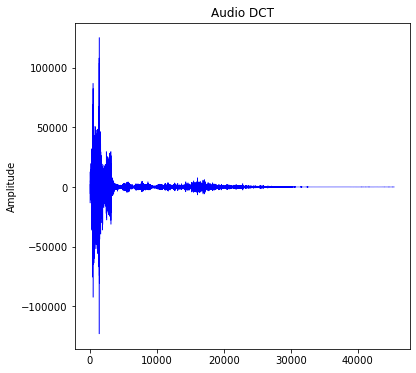

In [18]:
audio_dct = dct1d(audio[1])
numpy.save('audio_dct',audio_dct)
printAud(audio_dct, 'Audio DCT')

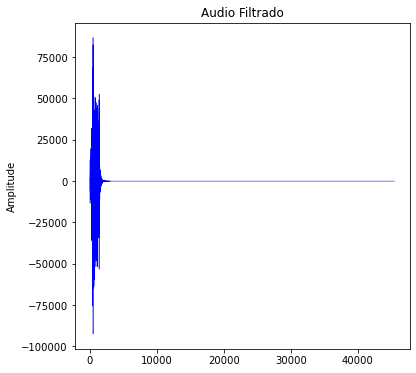

In [19]:
Xk = numpy.load('audio_dct.npy')
audio_dct_bt = ButterworthAudio(audio, 600, 8, Xk)
printAud(audio_dct_bt, 'Audio Filtrado')

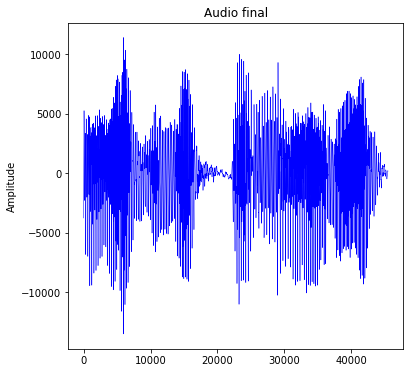

In [20]:
audio_idct = idct1d(audio_dct_bt)
printAud(audio_idct, 'Audio final')
saveAud(audio[0], audio_idct)